# Running MULTIGRIS: basic steps and programs

<font color=red>For best performance, it is advised to execute MULTIGRIS in the shell, as explained in the README. This notebook is just a way to illustrate a workflow. </font>

***
Motivations and goal:
- How to run the [MULTIGRIS programs](https://gitlab.com/multigris) in batch scripts
- Description of the various output products

The following context will be used:
- SFGX (star-forming galaxies with X-ray component; Ramambason et al. [2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..35R/abstract)) based on Cloudy models (Ferland et al. [2017](https://ui.adsabs.harvard.edu/abs/2017RMxAA..53..385F/abstract))

The various notebooks use some specific terms described in the file [TERMS.org](https://gitlab.com/multigris/mgris/-/blob/master/TERMS.org?ref_type=heads). 
***

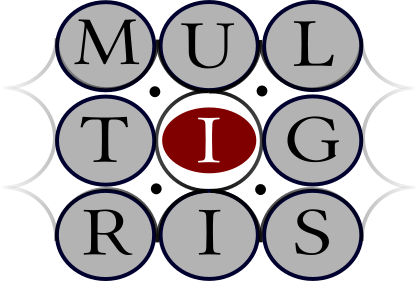

In [1]:
%load_ext autoreload
%autoreload 2
from wand.image import Image as WImage #this is to view PDFs
from IPython.display import Image
Image(filename='../Images/logo.png') 

## Table of contents:
* [Model table and context preparation](#s1)
* [Some settings](#s2)
* [Create the input file](#s3)
* [Run the search script](#s4)
* [Process results](#s5)
* [Plots](#s6)
* [Post-processing](#s7)
* [Diagnostics](#s8)
* [Going further](#s9)

## Model table and context preparation <a class="anchor" id="s1"></a>
***

We're not running from the program root directory so let's add it to the path in case the paths haven't already been setup (see [INSTALL file](https://gitlab.com/multigris/mgris/-/blob/master/INSTALL.org?ref_type=heads))

In [2]:
import sys, os
sys.path.append('../') 

We need to make sure that the model grid has been formatted and pre-processed to produce the file *model_grid.fth*. The pre-processing script may also be used to transform model columns (e.g., change scale) or to combine them and make new ones.

In [4]:
#this may take long depending on the grid size so we comment it here
#%run $context/pre-processing

## Some settings <a class="anchor" id="s2"></a>
***

In [5]:
import pickle
from Library.lib_main import closelogfiles

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


All output products will be saved there:

In [6]:
output_directory = './Runs/howto/general/'
os.makedirs(output_directory, exist_ok=True)

This will be the input file:

In [7]:
inputfile = output_directory+'/input.txt'

## Create the input file <a class="anchor" id="s3"></a>
***

In [8]:
import importlib
import Library.lib_input
importlib.reload(Library.lib_input)
from Library.lib_input import *

First get the object that contains all the input parameter definitions

In [9]:
params = get_params()

Setup the output directory

In [10]:
print(params['output'].description)
params['output'].value = output_directory

- Path (relative or absolute) to the output directory where results and plots are saved.
- If relative path, the MULTIGRIS root directory will be used.


Setup the context directory. The context contains the model tables, pre-defined configurations, and a context-specific input file with the definition of primary and secondary parameters... We will use the SFGX context for this example. 

In [11]:
print(params['context'].description)
params['context'].value = 'Contexts/mgris_sfgx/'´

- Path (relative or absolute) to context directory (i.e., where the context input file is located).
- If relative path, the MULTIGRIS root directory will be used.


We can use a pre-defined configuration from the context (here we use two components)

In [12]:
print(params['USE configuration'].description)
params['USE configuration'].value = '1C2S'

- Name of pre-defined configurations in the 'configurations.dat' file located in the context directory.


We can also use a specific configuration block to complement/replace the pre-defined configuration constraints. Below we show an example constraints between components or compared to actual values. In the configuration block, we can also specify the distribution (by default single, i.e., not as power-law, normal... distributions; see specific notebook) and the grid interpolation method (for single distributions only; by default nearest neighbor interpolation):

In [13]:
print(params['BEGIN configuration'].description)
params['BEGIN configuration'].value = '''age (0) < 0.2
Z (0) = -1 0.1
Lx (1) < (0)
distrib Z single linear'''

#let's comment this for now, this was just an example
params['BEGIN configuration'].comment()

- Any specific parameter constraints to complement/replace pre-defined configuration.
- Any constraint already in pre-defined configuration will be overwritten.
- Each parameter is described by default as a single distribution (i.e., not transformed into a power-law, normal... distribution)
  with nearest neighbor grid interpolation. 

- Syntax: 
   BEGIN configuration <name (optional)>
   distrib <param> <type: single/plaw/smoothplaw/brokenplaw/normal/doublenormal> <interpolation (only for single): nearest/linear>
   <constraint>
   <constraint>
   ...
   END


We can select a subset of the grid by fixing some parameters or by using lower/upper bounds ("hard" constraints)

In [14]:
print(params['select'].description)
params['select'].value = ['cut [2,2]', 'lum [9,9]' , 'Z_dust [0,0]', 'Tx [6,6]']

- Hard constraints to select a subset of the grid.
- Values correspond to the model table raw values (i.e., before any conversion if requested).

- Syntax: 
   select <parameter> [<lower_value>,<upper_value>]

- [,10] means value <=10, [2,] value >=2,
- [2,10] means value >=2 and <=10 (included), 
- [2,2] means =2,
- Possible to use 'min' and 'max', i.e., [min,min], [max,max],
- Possible to use more than two values, i.e., [2,8,10] will select only these values.


We can introduce systematic uncertainties as nuisance variables. We can use several groups of tracers and their associated systematic uncertainties like below

In [15]:
print(params['sysunc'].description)
params['sysunc'].value = ["elemental_abundances 0.2 ['O351.8004m', 'O1145.495m', 'O163.1679m', 'O388.3323m']",
                          "irs 0.2 ['Si234.8046m', 'S333.4704m', 'Ne524.2065m', 'Ne212.8101m', 'Ne315.5509m', 'Ne514.3228m']"]

#let's comment this for now, this was just an example
params['sysunc'].comment()

- A common scaling factor can be applied to groups of observables.

- Syntax
   sysunc label <sdev> ['<label1>','<label2>',... or else <setname>]
   sysunc label <mean> <sdev> ['<label1>','<label2>',... or else <setname>]
   (e.g., sysunc elemental_abundance_o 0.2 ['O351.8004m', 'O388.3323m'])

- Mean (optional) and sigma should be ***in log***. If mean is not provided, will assume 0. 
- If several observation sets are used, provide the full label (i.e., label{<set_name>}).
- It is also possible to simply provide the set name instead. 


Now we build the list of observables and values

In [16]:
labels = ['C2157.636m', 
          'O163.1679m', 
          'O388.3323m', 
          'N2205.244m', 
          'H217.0300m', 
          'Si234.8046m', 
          'Ne212.8101m', 
          'Ne315.5509m', 
          'Ne514.3228m']
values = [10**39.60373,
          10**39.96645,
          10**39.23215,
          10**36.51495,
          10**38.50008,
          10**39.61371,
          10**38.22829,
          10**39.30396,
          10**37.52060]

print(params['BEGIN observations'].description)
params['BEGIN observations'].value = ''
for i,l in enumerate(labels):
    params['BEGIN observations'].value += '{} {}\n'.format(l, values[i])
params['BEGIN observations'].extras.update({'delta_ref': 1e36,  #we can define an error that will be used for all tracers with no observed errors
                                            'delta_add': 0.1})  #we can add a 10% error
# the fluxes are defined by default in linear scale, for log scale:
# params['BEGIN observations'].extras.update({'scale': 'log'})
#The scaling factor makes it possible to scale all the observed values. 
#Depending on the scale used for the observation block, this is a value added for log scale or multiplied for linear scale.
params['BEGIN observations'].extras.update({'scale_factor': 1})

- List of observations, potentially split in several sets.

- Syntax: 
   BEGIN observations <linear/log> <disabled> <predict> <name>
   <label> <value> <error> 
   <label> <value> <error+> <error->
   END

- Observation sets:
  - Possible to provide several observation sets. Each set can be disabled individually (see below). 
- Header keywords:
  - Disable a set without commenting it: 'BEGIN observations disabled'.
  - If the predict keyword is present, all observables from the set will be appended to obs_to_predict for post-processing.
  - An optional name can be given to each set which is appended to the label later on for results (default: SET1, SET2...). 
- Values:
  - Can be nan (will be ignored; prediction with mgris_post_process).
- Errors:
  - Can be nan (will be ignored; prediction with mgris_post_process).
  - Can be asymmetric (+ then -).
  - Set by default to delta_ref if no value provided.
  - Each set may use a delta_ref value, which is used for all observables that do n

The scaling factor is used to scale modelled values to the observations. 

In [17]:
print(params['use_scaling'].description)
params['use_scaling'].value = "'all'"

#use only one tracer: params['use_scaling'].value = "'TIR1800.00m'"

- Models are scaled to observations using a single scaling random variable.
- Specify here the observable(s) that will be used to estimate the prior:
  - all observables ('all'),
  - a subset (['<label1>', '<label2>']),
  - one observable (['<label>']),
  - or none ('none'): observations are directly compared to the modeled values,
- If several sets are used, provide full label (i.e., label{<set_name>}).
- If a specific combination (e.g, sum) of observables is to be used, create the corresponding column in the context
  pre-processing.py file beforehand and propagate the observed value & uncertainty in the observations set. 


These new observables below will be calculated using the PDF of the primary paramters once the inference is done

In [18]:
print(params['obs_to_predict'].description)
params['obs_to_predict'].value = ['H16562.81A', 'N2121.767m', 'O351.8004m', 'Ne524.2065m', 'O1145.495m', 'S333.4704m', 'Ne53426.03A', 'H14861.33A'] 

- Observables not used for inference can be predicted with mgris_post_process.
- The observables can be in the main grid or in the post-processing grid.


These secondary parameters will be calculated using the PDF of the primary parameters once the inference is done

In [19]:
print(params['secondary_parameters'].description)
params['secondary_parameters'].value = ['MHII']

- Parameters (not used for inference) can be predicted with mgris_post_process.
- The parameters can be in the main grid or in the post-processing grid.  


We can use some context-specific rules with some additional random variables to be defined in the context library file

In [20]:
print(params['active_rules'].description)
params['active_rules'].value = ['extinction']

#let's comment this for now, this was just an example
params['active_rules'].comment()

- List of rule names, to be defined in 'Contexts/<context>/Library/lib.py'.


Finally write down the input file

In [21]:
make_input(params, inputfile)

In [22]:
inputfile

'./Runs/howto/general//input.txt'

This is how it looks like

In [23]:
%cat $inputfile

##################################
#### INPUT FILE FOR MULTIGRIS ####
##################################

# Generated automatically
# Date: Fri 06 September 2024 - 20:40:36
    

#------------------------------------------------------------------
#VERSIONS
#------------------------------------------------------------------

# Python
#  - version      : 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
#  - bin          : /local/home/vleboute/miniconda3/bin/python
#  - prefix       : /local/home/vleboute/miniconda3

# PyMC
#  - version      : 5.16.2

# mgris
#  - git commit   : 1a38371
#  - (date)       : 2024-09-06 08:20:37 +0200
#  - (submodules) : 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15

#------------------------------------------------------------------





#---------------------------------------------------------------------
#OUTPUT
#---------------------------------------------------------------------

# OUTPUT PATH (Mandator

Note that you can modify the input file manually or even write it from scratch but it is advised to use the above method to generate an input file, for the following reasons:
- the above method writes the git repository versions for the code and context, which is useful for reproducibility
- it is easier to produce many input files in case of a large dataset

## Run the search script <a class="anchor" id="s4"></a>
***

Import the main program

In [24]:
import mgris_search

Checking path in case several copies exist

In [25]:
mgris_search.__file__

'/local/home/vleboute/work/MULTIGRIS/mgris/mgris_search.py'

Run the search algorithm. Here we force the number of samples (per chain/job). We choose a rather small number to make a quick run. Better looking posterior distributions would be found by increasing the number of samples (see specific notebook).

We leave the interpolation order automatic (it will be 0 for all parameters except Z).

In [26]:
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, nsamples_per_job=250))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S
Input file not copied because identical to destination

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor

[9 8 5 5 8 3]
-> [9 1 5 5 8 3]
[9 1 5 5 8 3]


u 0: single value (nearest neighbor grid interpolation)


-> [9 1 1 5 8 3]
[9 1 1 5 8 3]


Z 0: single value (nearest neighbor grid interpolation)


-> [9 1 1 1 8 3]
[9 1 1 1 8 3]


Lx 0: single value (nearest neighbor grid interpolation)


-> [9 1 1 1 1 3]
[9 1 1 1 1 3]


age 1: single value (nearest neighbor grid interpolation)
n 1: single value (nearest neighbor grid interpolation)
u 1: single value (nearest neighbor grid interpolation)


-> [9 1 1 1 1 1]
[9 8 5 5 8 3]
-> [9 1 5 5 8 3]
[9 1 5 5 8 3]
-> [9 1 1 5 8 3]


Z 1: single value (nearest neighbor grid interpolation)


[9 1 1 5 8 3]
-> [9 1 1 1 8 3]


Lx 1: single value (nearest neighbor grid interpolation)


[9 1 1 1 8 3]
-> [9 1 1 1 1 3]
[9 1 1 1 1 3]
-> [9 1 1 1 1 1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Z_0, idx_age_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
Sampling: [idx_Lx_0, idx_Z_0, idx_age_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.003  0.525   0.095    1.893      0.023    0.016     522.0   
idx_Lx_1         1.003  0.525   0.095    1.893      0.023    0.016     522.0   
idx_Z_0          3.392  1.847   0.575    6.884      0.081    0.057     495.0   
idx_Z_1          3.392  1.847   0.575    6.884      0.081    0.057     495.0   
idx_age_0        3.406  1.832   0.313    6.495      0.081    0.058     529.0   
idx_age_1        3.406  1.832   0.313    6.495      0.081    0.058     529.0   
idx_n_0          1.987  1.123   0.017    3.711      0.049    0.035     516.0   
idx_n_

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 20:41:19.646128
Time used           : 0.7 min.
Sampling time used  :  0.33 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 765045 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                0.9

Display full log

In [27]:
%cat $output_directory/Logs/output_search.txt

[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨✨✨✨✨
[⏲ 2024-09-06 20:41:19]	    INFO	   mgris_search: 	✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
[⏲ 20

Input parameters and some output parameters are accessible in the files input.pkl and results_search.pkl:

In [28]:
with open(output_directory+'input.pkl', 'rb') as f:
    res = pickle.load(f)
print(res.keys())

print()

with open(output_directory+'results_search.pkl', 'rb') as f:
    res = pickle.load(f)
print(res.keys())

dict_keys(['input_file_lines', 'context', 'contextshort', 'configuration', 'linterp_params', 'plaw_params', 'smoothplaw_params', 'brokenplaw_params', 'normal_params', 'doublenormal_params', 'directory_models', 'output_directory', 'post_processing_file', 'params_name', 'hierarchical', 'observation_sets', 'tolog', 'tolinear', 'obs_notmeasured_to_infer', 'obs_to_predict', 'params_to_predict', 'use_scaling', 'n_comps', 'n_comps_vary', 'groups', 'sorting', 'obs_skiplikelihood', 'intensive_obs', 'intensive_secondary_parameters', 'intensive_secondary_parameters_noweight', 'extensive_secondary_parameters', 'active_rules', 'discrete_params', 'pmextra', 'use_scaling_specific', 'true_parameters', 'select', 'sysunc', 'sector_colors', 'upper_limit_sigma', 'gridnanisnan', 'maxgridmemsize', 'type_constraints', 'StudentT_nu', 'inference_upsample', 'linterp_upsample', 'ignore_model_upper_limits', 'precision', 'inference_backend', 'ncores_max', 'nchains_percore', 'nsamples_per_chain_min', 'nsamples_per_

## Process results <a class="anchor" id="s5"></a>
***

The processing script formats the result, identifies and isolate the components, produces plots etc...

In [29]:
import mgris_process

In [30]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:41:22
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/howto/general//input.txt
    ┝ - output directory   : ./Runs/howto/general/
    ┕========================================┙
    
List of tracers w

Display full log

In [31]:
%cat $output_directory/Logs/output_process.txt

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	       ┍ M U L ┑
[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	       ┝ T I G ┥
[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	       ┕ R I S ┙
[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	     ┍            ┑
[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	     ┝ PROCESSING ┥
[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	     ┕            ┙
[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	

[⏲ 2024-09-06 20:41:22]	    INFO	  mgris_process: 	Thanks for using MULTIGRIS.
[⏲ 2024-09-06 20:41:22]	   

### Results

Just display the main results in a convenient way:

In [32]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   0.957  0.256   0.517    1.386      0.011    0.008     527.0     441.0   1.01
idx_Lx_1   0.957  0.256   0.517    1.386      0.011    0.008     527.0     441.0   1.01
idx_Z_0    2.022  0.260   1.615    2.497      0.013    0.009     478.0     520.0   1.02
idx_Z_1    2.022  0.260   1.615    2.497      0.013    0.009     478.0     520.0   1.02
idx_age_0  3.118  0.636   2.066    4.504      0.028    0.020     495.0     504.0   1.01
idx_age_1  3.118  0.636   2.066    4.504      0.028    0.020     495.0     504.0   1.01
idx_n_0    2.940  0.260   2.519    3.382      0.011    0.008     529.0     507.0   1.00
idx_n_1    1.983  0.271   1.542    2.453      0.012    0.009     478.0     406.0   1.01
idx_u_0    2.997  0.265   2.516    3.401      0.013    0.009     423.0     423.0   1.00
idx_u_1    1.027  0.265   0.623    1.486      0.011    0.008     574.0     521.0   1.00
scale      0.285  0.028   0.245

Results are also saved in the file _results_process.pkl_, with in particular the estimators:

In [33]:
with open(output_directory+'results_process.pkl', 'rb') as f:
    res = pickle.load(f)
print(res.keys())

print()

print('Reading mean for parameter Z_0')
print(res['estimators']['Z_0'].keys())
print(res['estimators']['Z_0']['mean'])

dict_keys(['prior_predictive', 'estimators', 'pvalues', 'loo_elpd', 'waic_elpd', 'log_marginal_likelihood', 'estimators_combined', 'ci_val_combined', 'pvalue_combined', 'pnsigma', 'params_forplots', 'paramnames_forplots'])

Reading mean for parameter Z_0
dict_keys(['robust_mean', 'robust_variance', 'robust_stdev', 'robust_covariance', 'robust_skewness', 'median', 'rho', 'mu', 'lambda', 'tau', 'stdev', 'mad', 'mean', 'hpdi', 'hpdi_all', 'ci'])
-1.2232082482201345


Anf of course the "trace" object itself, containing the posterior distribution:

In [34]:
import arviz as az
t = az.from_netcdf(output_directory+'trace_process.netCDF')
t

Inference data with groups:
	> posterior
	> log_likelihood

## Plots <a class="anchor" id="s6"></a>
***

### Autocorrelation

The following plot shows the autocorrelation for all parameters. 

Note: if you have issues with WImage on Linux, try adding ```<policy domain="coder" rights="read | write" pattern="PDF" />``` in /etc/ImageMagick-?/policy.xml

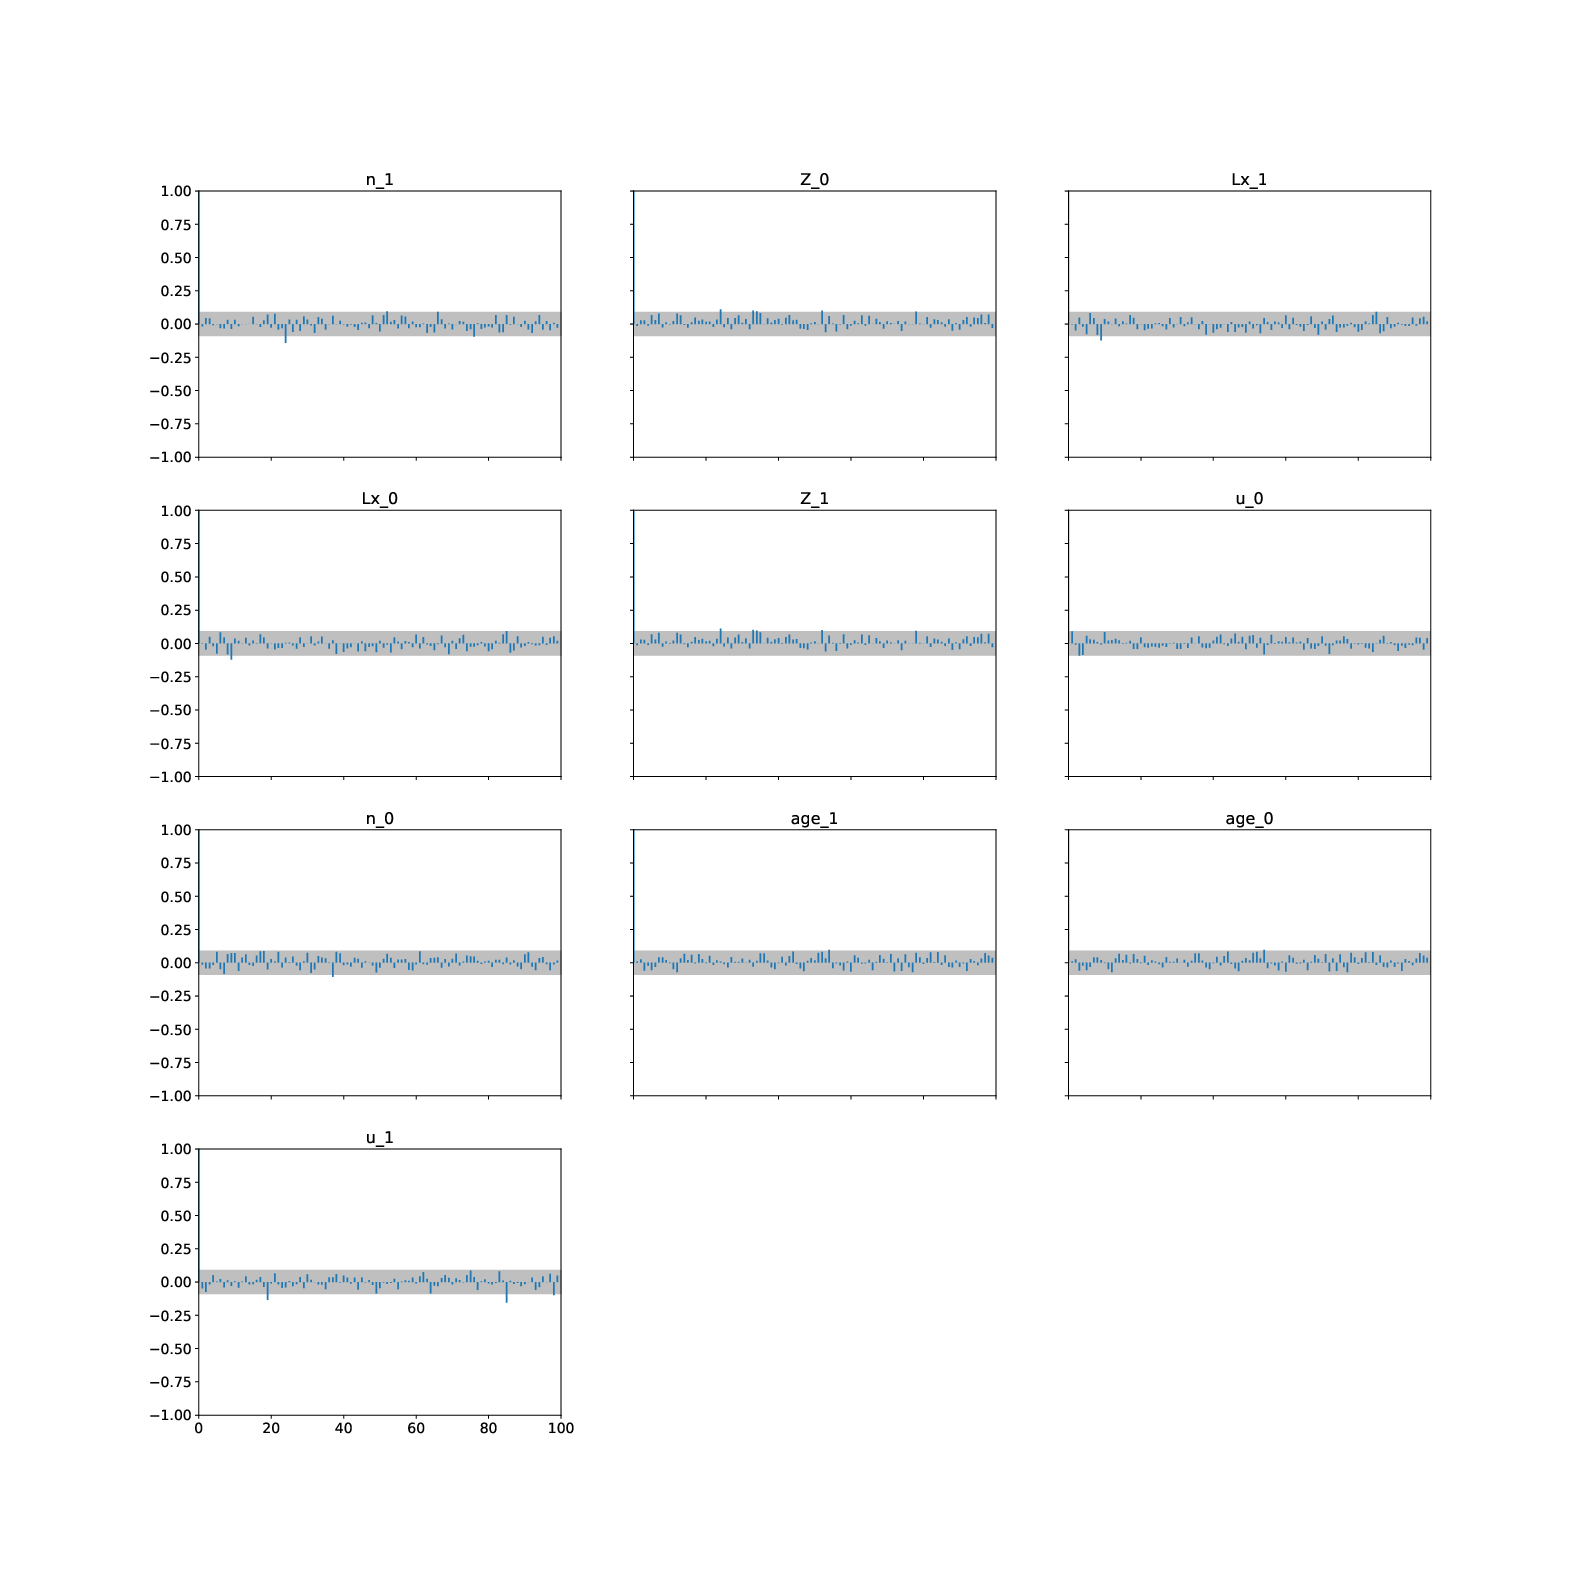

In [35]:
WImage(filename=output_directory+'Plots/autocorr_combined.pdf') 

### Trace

The following plots show the posterior distribution ("trace") of each random variable (and also the likelihood) for each chain (job for the SMC sampler), as a PDF on the left and the right panel shows the "rank" for each individual chain, which should ideally be flat. 

We show first a version with all chain traces plotted (PDF is per chain so if chains don't sample the same region, there may be several peaks corresponding to each chain).

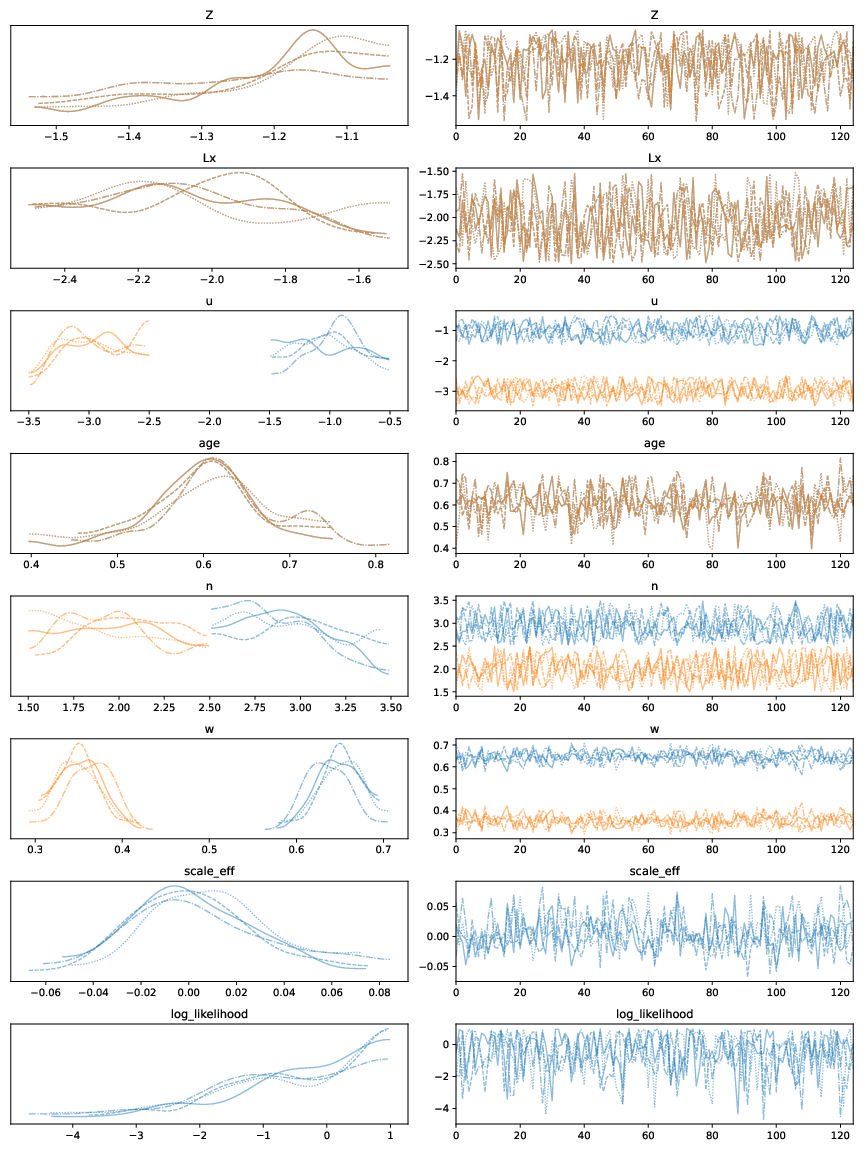

In [36]:
WImage(filename=output_directory+'Plots/Trace_params.pdf') #use Trace_params_0.pdf to see the individual chains, Posterior_dist_params.pdf for a simple PDF

Then we show a version with all chains combined (PDF of all chains combined). The vertical stripes indicate the confidence interval and the gray shaded curve shows the prior distribution. 

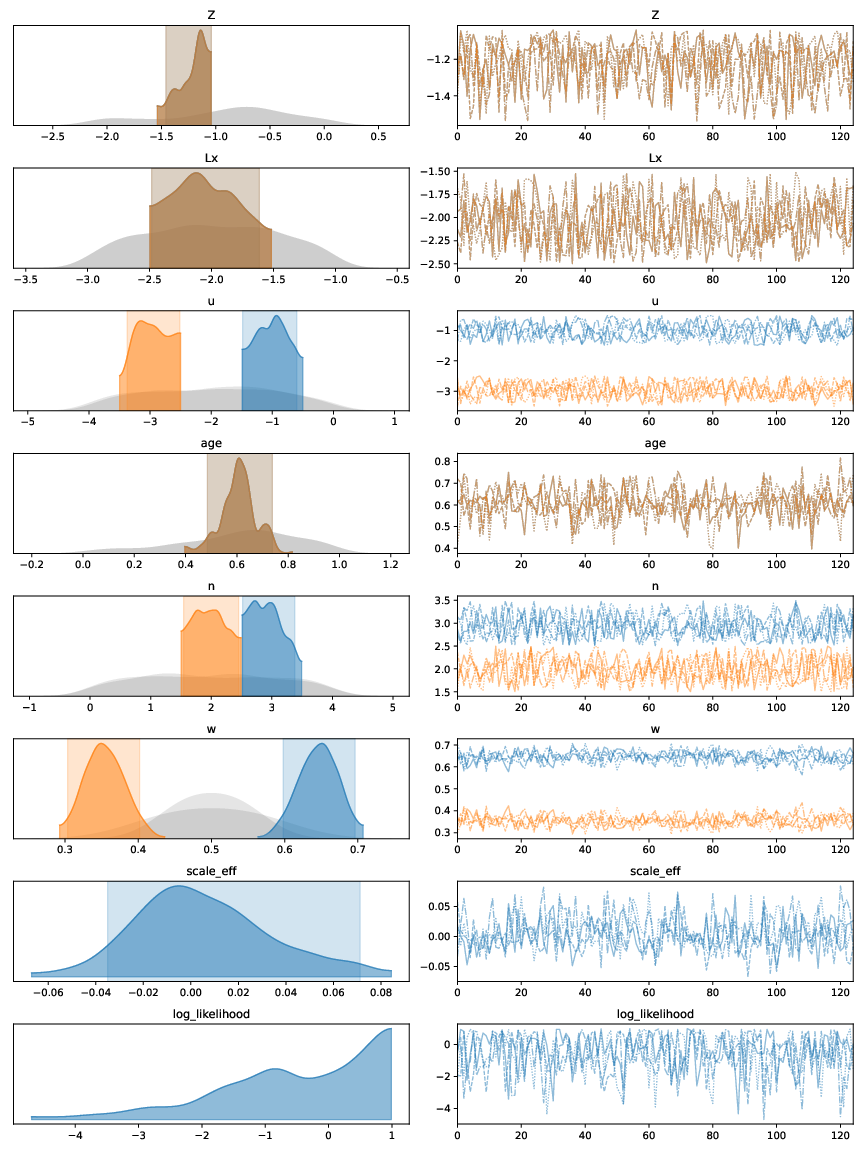

In [37]:
WImage(filename=output_directory+'Plots/Trace_params_combined.pdf') #use Trace_params_0.pdf to see the individual chains, Posterior_dist_params.pdf for a simple PDF

### Corner plot

The following plot shows the corner plot for a given component

Here skipping because too many parameters

In [38]:
# WImage(filename=output_directory+'Plots/Corner_plot_0.pdf')

### KDE

The following plot shows the kernel density estimate, including all components. The KDE is a nice way to identify potential correlations between parameters.

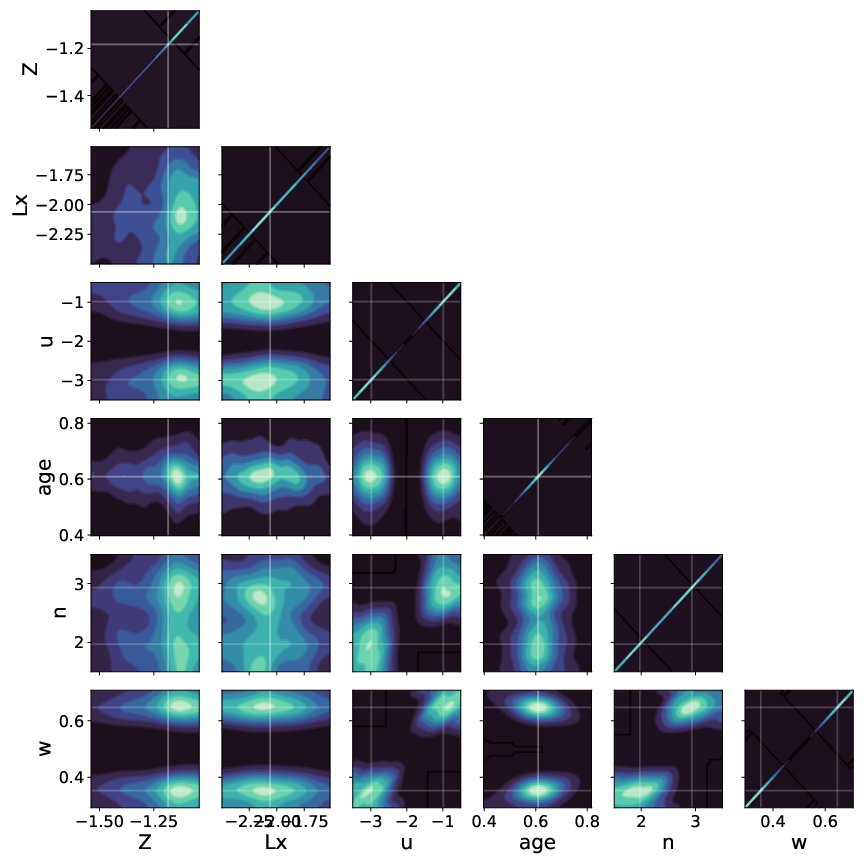

In [39]:
WImage(filename=output_directory+'Plots/kde_plot.pdf') 

### Posterior distribution

The following plot shows the posterior distribution of all the tracers. The vertical black lines show the observed value and errors. The black curve shows a Gaussian centered on the observed value with the standard deviation as the error.  

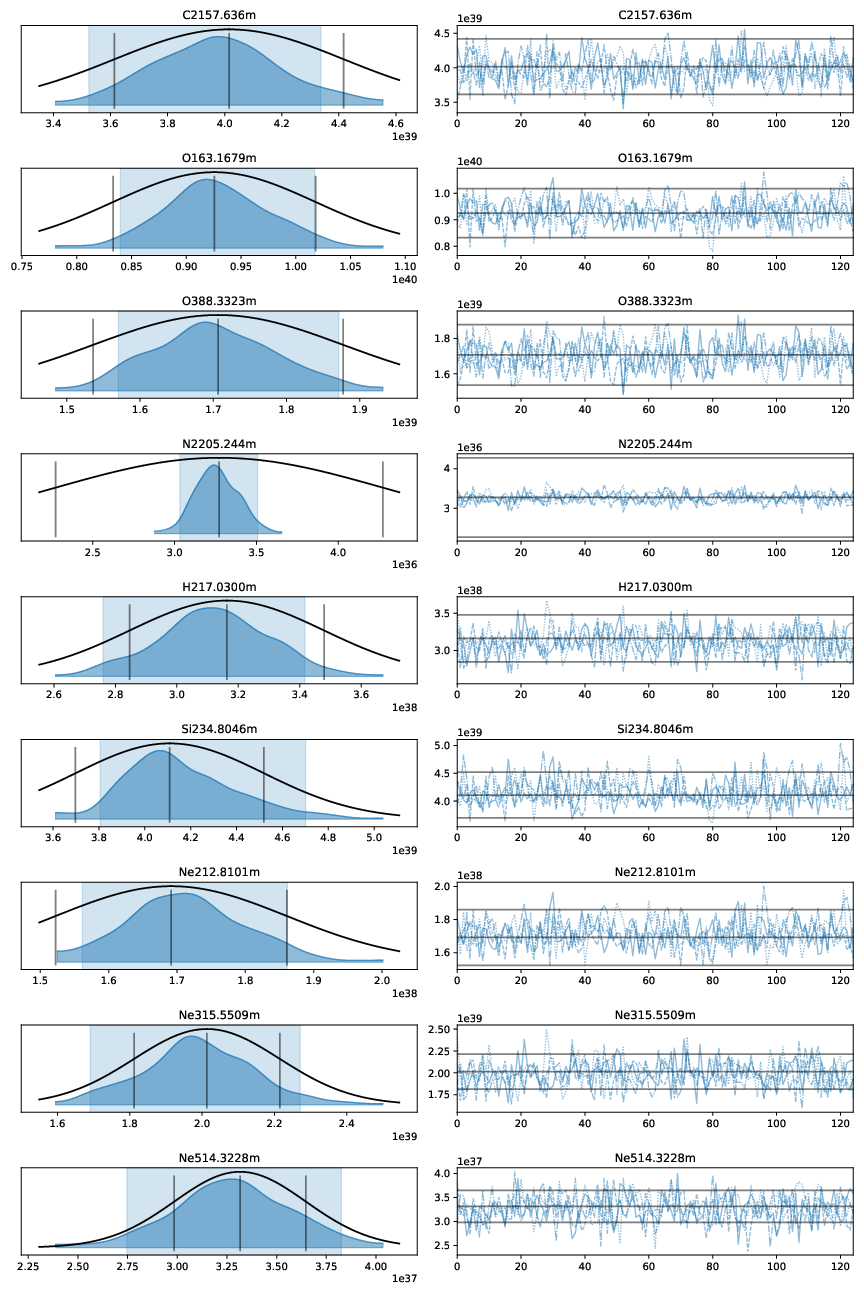

In [40]:
WImage(filename=output_directory+'Plots/Trace_observables_combined.pdf') #use Trace_observables.pdf to see the individual chains, Posterior_dist_obs.pdf for a simple PDF

### Component contributions

The following plot shows the contribution from each component to each tracer

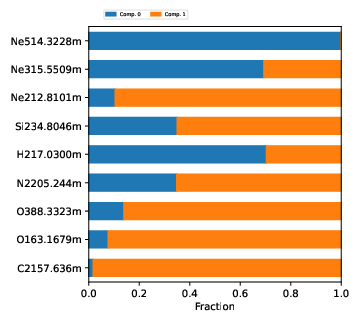

In [41]:
WImage(filename=output_directory+'Plots/fracplot_components.pdf') #use fracplot_groups.pdf and fracplot_both.pdf if considering several groups

### Comparison model vs. observations

The following plot shows the comparison between the predicted values and the observed values. The black circle shows the predicted values and the associated HPDI (highest posterior density interval). Observed values and the associated uncertainties are displayed in red. Green sectors indicate an agreement with errors. 

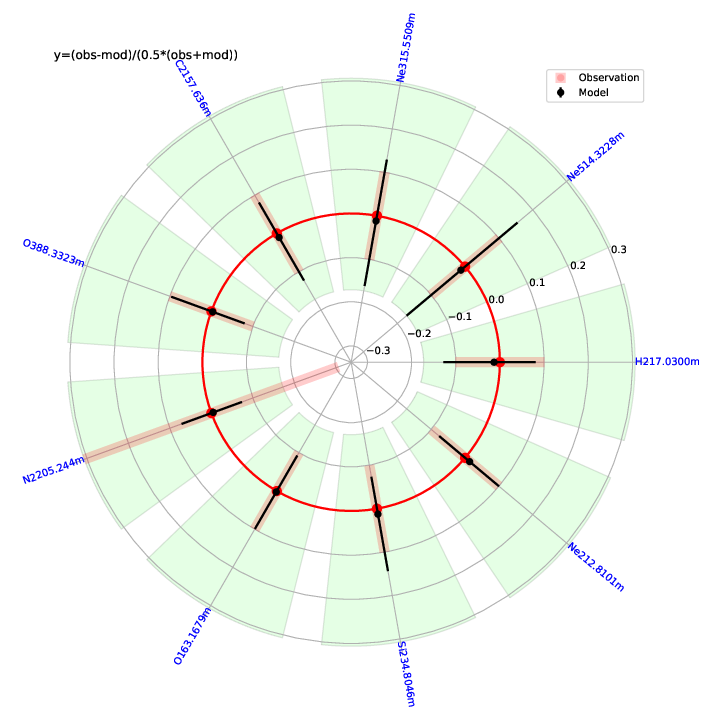

In [42]:
WImage(filename=output_directory+'Plots/matchplot_disk.pdf') #use matchplot.pdf instead for a vertical layout

For the match plot, green means the observed value and modeled value agree within intervals (error bar and high-probability density intervals respectively), yellow means intervals are just overlapping, and red means intervals are not overlapping. 

### Violin plots

The following plots the PDFs for the observables

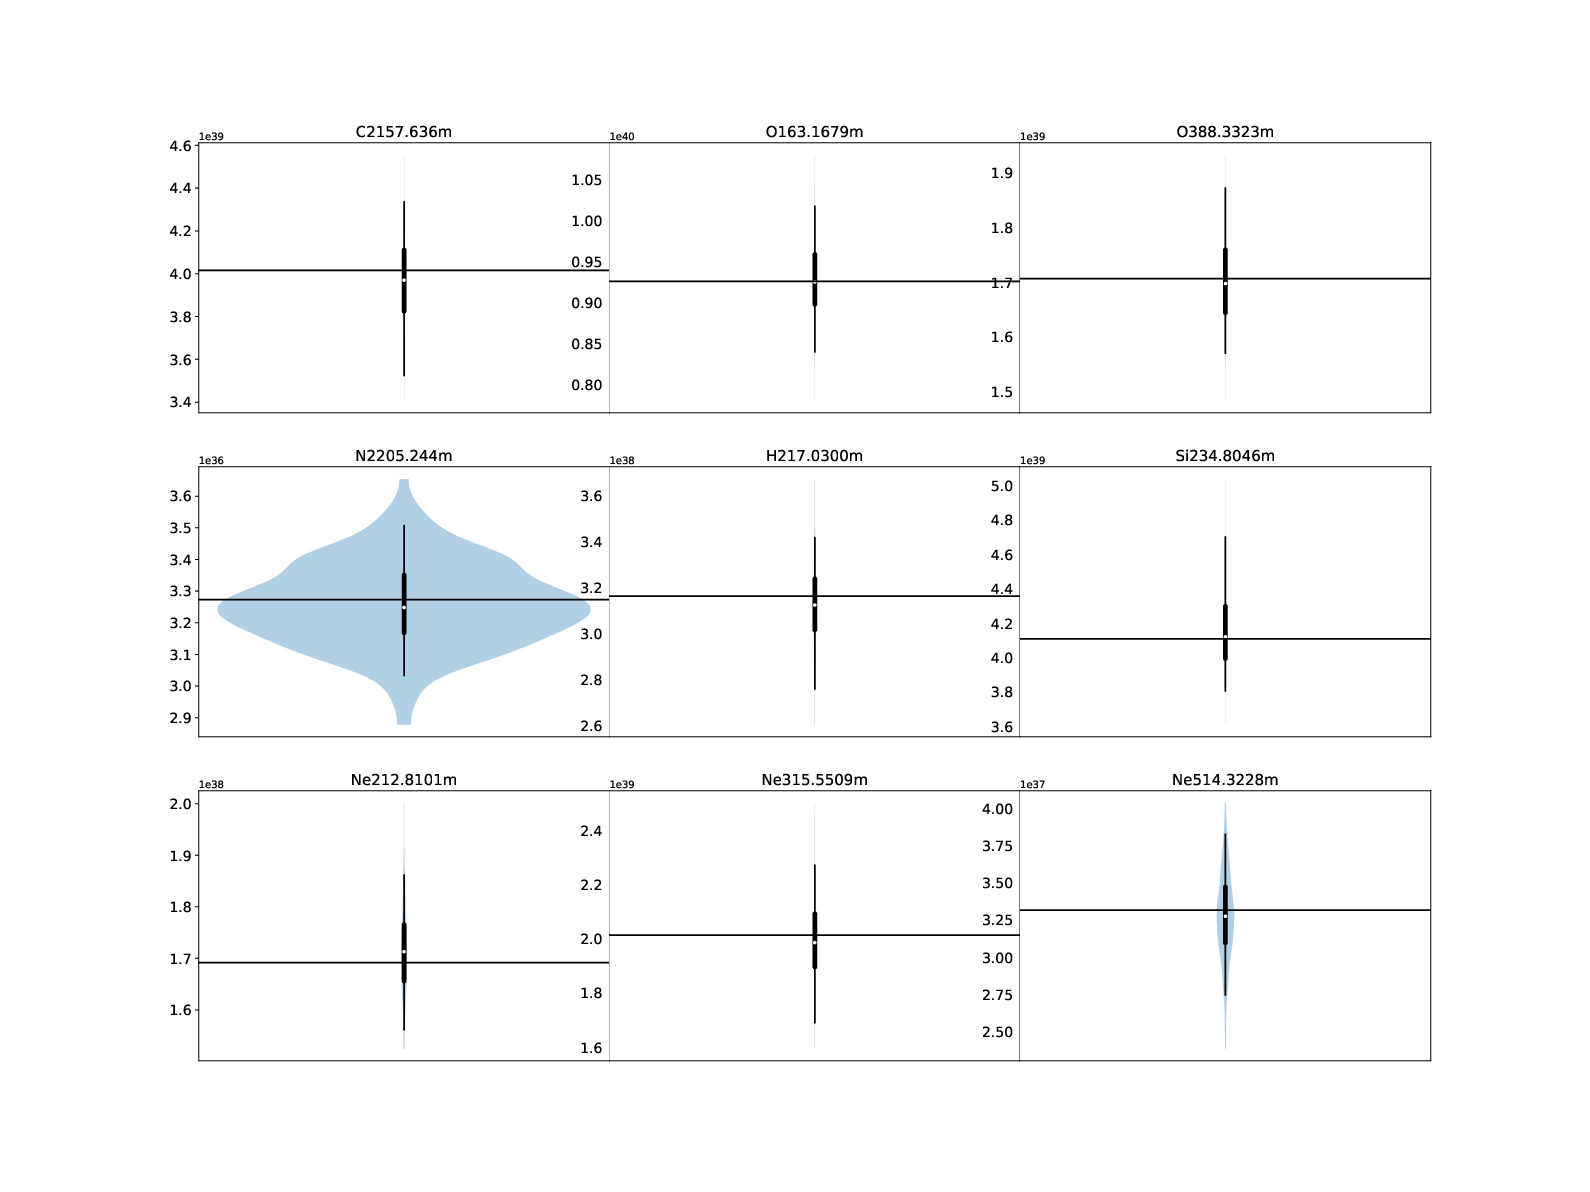

In [43]:
WImage(filename=output_directory+'Plots/Violin_obs.pdf') #check Violin_obs_norm.pdf for a version scaled with sigma values

This is the version with all observables (scaled with sigma values) combined

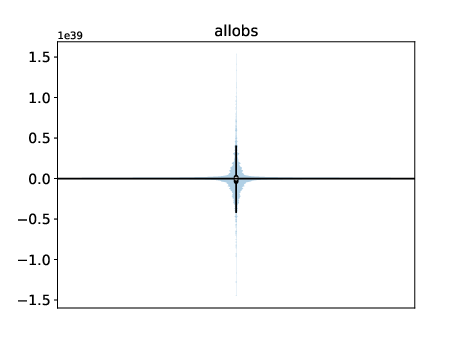

In [44]:
WImage(filename=output_directory+'Plots/Violin_all_obs.pdf') 

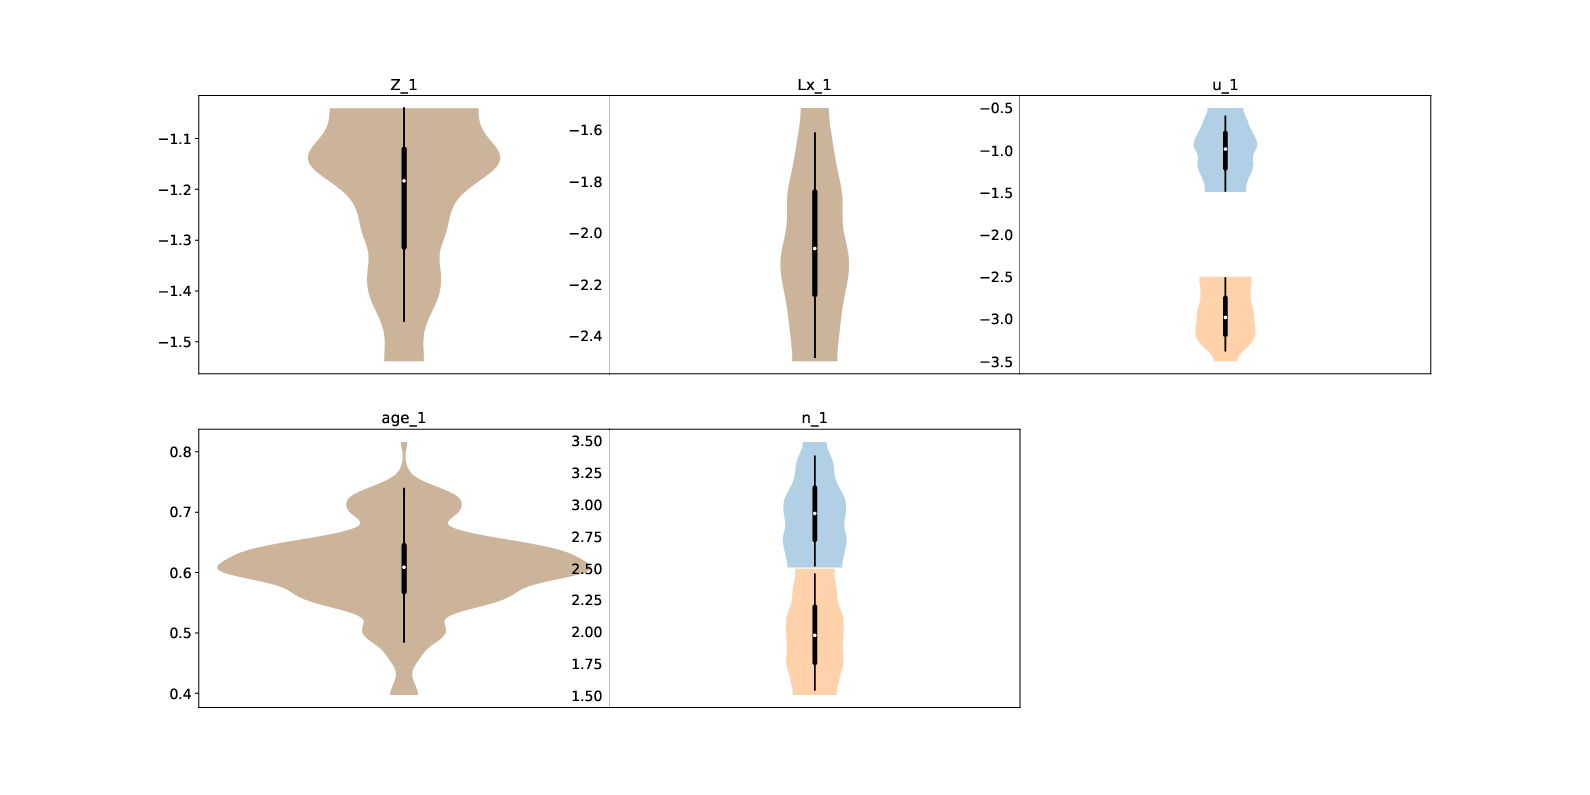

In [45]:
WImage(filename=output_directory+'Plots/Violin_params.pdf') 

## Post-processing <a class="anchor" id="s7"></a>
***

The post-processing step makes it possible to calculates PDFs of secondary parameters or unboserved observables in the model grid without any observed value

In [46]:
import mgris_post_process

In [47]:
closelogfiles() #in case run was interrupted
mgris_post_process.main(args=mgris_post_process.args(inputfile=inputfile))







          ┍ M U L ┑
          ┝ T I G ┥
          ┕ R I S ┙






     ┍                 ┑
     ┝ POST-PROCESSING ┥
     ┕                 ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 20:41:55
    ┕========================================┙
   
-- Using pre-defined configuration 1C2S

    Run summary
    - input file         : ./Runs/howto/general//input.txt
    - output directory   : ./Runs/howto/general/
    
Loading multi-trace...
Reading post-processing file ['post_processing_all_cutAv.fth', '#model_number']
Reading Feather file... /local/home/vleboute/work/MULTIGRIS/mgris/Contexts/mgris_sfgx/Grids/model_grid.fth (run pre-processing script if the latter needs to

In [48]:
%cat $output_directory/Logs/output_postprocess.txt

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	          ┍ M U L ┑
[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	          ┝ T I G ┥
[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	          ┕ R I S ┙
[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	     ┍                 ┑
[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	     ┝ POST-PROCESSING ┥
[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	     ┕                 ┙
[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgris_post_process: 	

[⏲ 2024-09-06 20:41:55]	    INFO	mgri

Like for the processing script, results for the post-processing can also be found in the file results_post-process:

In [49]:
import pickle
with open(output_directory+'results_post-process.pkl', 'rb') as f:
    res = pickle.load(f)
print(res.keys())

print()

print('Reading mean for parameter MHII')
print(res['estimators']['MHII'].keys())
print(res['estimators']['MHII']['mean'])

dict_keys(['estimators', 'obs_to_predict', 'params_to_predict'])

Reading mean for parameter MHII
dict_keys(['robust_mean', 'robust_variance', 'robust_stdev', 'robust_covariance', 'robust_skewness', 'median', 'rho', 'mu', 'lambda', 'tau', 'stdev', 'mad', 'mean', 'hpdi', 'hpdi_all', 'ci'])
5.761171


The PDF for unobserved tracers

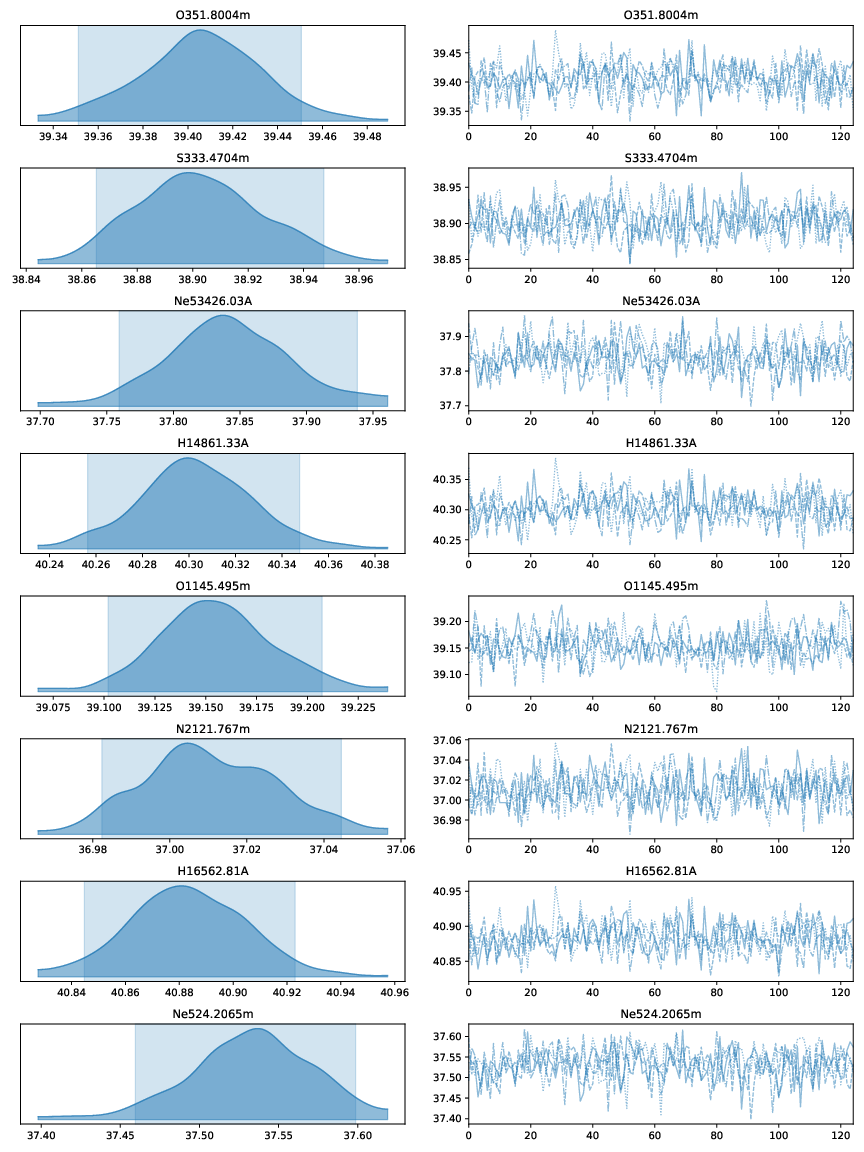

In [50]:
WImage(filename=output_directory+'Plots/Trace_observables_predict_combined.pdf') 

The PDF for secondary parameters

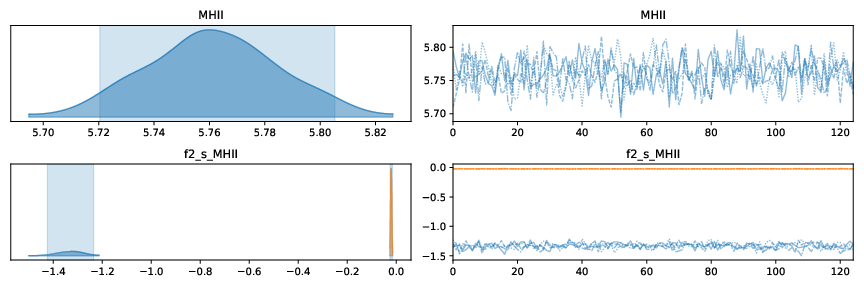

In [51]:
WImage(filename=output_directory+'Plots/Trace_params_predict_combined.pdf') 

## Diagnostics <a class="anchor" id="s8"></a>
***

Now we check some diagnostics to make sure, among other things, that the solution has converged. See also specific notebooks.

In [52]:
import mgris_diagnose

In [53]:
closelogfiles() #in case run was interrupted
mgris_diagnose.main(args=mgris_diagnose.args(inputfile=inputfile))


    System summary
    - Date/time         : 06/09/2024 20:42:04
    
-- Using pre-defined configuration 1C2S

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓



- ESS informs if the chains are large enough (effective number of uncorrelated draws)
  - bulk: sampling efficiency in the bulk of the distribution (related to efficiency of mean and median estimates)
  - tail: minimum for 5% and 95% quantiles.
- rhat informs if the chains mix well
- MCSE estimates the error introduced by sampling and thus the level of precision of our estimates
    
    

 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
 ▒ CHECKING PARAMETERS ▒
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
age_0  0.607  0.069   0.485    0.739      0.003    0.002     495.0     504.0   1.01
n_0    2.940  0.260   2.519    3.382      0.011    0.008     529.0     507.0   1.00
n_1    1.983  0.271   1.542    2.453      0.012    0.009     478.0     406.0   1.01
u_0   -1.003  0.265  -1.4

- We wanna check in particular the effective sample sizes and rhat values (see https://ui.adsabs.harvard.edu/abs/2019arXiv190308008V/abstract)

## Going further <a class="anchor" id="s9"></a>
***

- Check this [notebook](2_How_to_run_number_of_samples.ipynb) to assess the number of samples.
- Check this [notebook](3_How_to_run_convergence_checks.ipynb) to improve the runs and the diagnostics.
- Check this [notebook](4_How_to_run_advanced.ipynb) to explore other options for each step.
- Check this [notebook](5_How_to_run_datasets.ipynb) to use MULTIGRIS on several/many datasets.
- Check the [ISM application notebooks](ISM_applications.ipynb) for in-depth examples.